In [7]:
import os
import io

import detectron2

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import some common libraries
import numpy as np
import cv2
import torch

# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [8]:
# Load VG Classes
data_path = 'data/genome/1600-400-20'

vg_classes = []
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())

vg_attrs = []
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for object in f.readlines():
        vg_attrs.append(object.split(',')[0].lower().strip())


MetadataCatalog.get("vg").thing_classes = vg_classes
MetadataCatalog.get("vg").attr_classes = vg_attrs

In [9]:
cfg = get_cfg()
cfg.merge_from_file("../configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml")
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 300
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
# VG Weight
cfg.MODEL.WEIGHTS = "http://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr.pkl"
predictor = DefaultPredictor(cfg)

Config '../configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Modifications for VG in ResNet Backbone (modeling/backbone/resnet.py):
	Using pad 0 in stem max_pool instead of pad 1.

Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/roi_heads.py):
	1. Change the stride of conv1 and shortcut in Res5.Block1 from 2 to 1.
	2. Modifying all conv2 with (padding: 1 --> 2) and (dilation: 1 --> 2).
	For more details, please check 'https://github.com/peteanderson80/bottom-up-attention/blob/master/models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'.

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401



In [10]:
# coding=utf-8
# Copyleft 2019 Project LXRT

import sys
import csv
import base64
import time

import numpy as np

csv.field_size_limit(sys.maxsize)
FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              "attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]


def load_obj_tsv(fname, topk=None):
    """Load object features from tsv file.

    :param fname: The path to the tsv file.
    :param topk: Only load features for top K images (lines) in the tsv file.
        Will load all the features if topk is either -1 or None.
    :return: A list of image object features where each feature is a dict.
        See FILENAMES above for the keys in the feature dict.
    """
    data = []
    start_time = time.time()
    print("Start to load Faster-RCNN detected objects from %s" % fname)
    with open(fname) as f:
        reader = csv.DictReader(f, FIELDNAMES, delimiter="\t")
        for i, item in enumerate(reader):

            for key in ['img_h', 'img_w', 'num_boxes']:
                item[key] = int(item[key])
            
            boxes = item['num_boxes']
            decode_config = [
                ('objects_id', (boxes, ), np.int64),
                ('objects_conf', (boxes, ), np.float32),
                ('attrs_id', (boxes, ), np.int64),
                ('attrs_conf', (boxes, ), np.float32),
                ('boxes', (boxes, 4), np.float32),
                ('features', (boxes, -1), np.float32),
            ]
            for key, shape, dtype in decode_config:
                item[key] = np.frombuffer(base64.b64decode(item[key]), dtype=dtype)
                item[key] = item[key].reshape(shape)
                item[key].setflags(write=False)

            data.append(item)
            if topk is not None and len(data) == topk:
                break
    elapsed_time = time.time() - start_time
    print("Loaded %d images in file %s in %d seconds." % (len(data), fname, elapsed_time))
    return data

data = load_obj_tsv('data/caffe_coco_features/train2014_obj36.tsv')


Start to load Faster-RCNN detected objects from data/caffe_coco_features/train2014_obj36.tsv
Loaded 10 images in file data/caffe_coco_features/train2014_obj36.tsv in 0 seconds.


In [11]:
NUM_OBJECTS = 36

from torch import nn

from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image
from detectron2.structures.boxes import Boxes
from detectron2.structures.instances import Instances

def doit(raw_image, raw_boxes):
        # Process Boxes
    raw_boxes = Boxes(torch.from_numpy(raw_boxes))
    
    with torch.no_grad():
        raw_height, raw_width = raw_image.shape[:2]
#         print("Original image size: ", (raw_height, raw_width))
        
        # Preprocessing
        image = predictor.transform_gen.get_transform(raw_image).apply_image(raw_image)
#         print("Transformed image size: ", image.shape[:2])
        
        # Scale the box
        new_height, new_width = image.shape[:2]
        scale_x = 1. * new_width / raw_width
        scale_y = 1. * new_height / raw_height
        #print(scale_x, scale_y)
        boxes = raw_boxes.clone()
        boxes.scale(scale_x=scale_x, scale_y=scale_y)
        
        # ----
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": raw_height, "width": raw_width}]
        images = predictor.model.preprocess_image(inputs)
        
        # Run Backbone Res1-Res4
        features = predictor.model.backbone(images.tensor)
        
        # Run RoI head for each proposal (RoI Pooling + Res5)
        proposal_boxes = [boxes]
        features = [features[f] for f in predictor.model.roi_heads.in_features]
        print('proposal_boxes: ', proposal_boxes)
        print('in_features: ', predictor.model.roi_heads.in_features)
        print([f.mean() for f in features], [f.shape for f in features])
        box_features = predictor.model.roi_heads._shared_roi_transform(
            features, proposal_boxes
        )
        feature_pooled = box_features.mean(dim=[2, 3])  # pooled to 1x1
#         print('Pooled features size:', feature_pooled.shape)
        
        # Predict classes        pred_class_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled) and boxes for each proposal.
        pred_class_logits, pred_attr_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled)
        pred_class_prob = nn.functional.softmax(pred_class_logits, -1)
        pred_scores, pred_classes = pred_class_prob[..., :-1].max(-1)
        
        attr_prob = pred_attr_logits[..., :-1].softmax(-1)
        max_attr_prob, max_attr_label = attr_prob.max(-1)
        
        # Detectron2 Formatting (for visualization only)
        roi_features = feature_pooled
        instances = Instances(
            image_size=(raw_height, raw_width),
            pred_boxes=raw_boxes,
            scores=pred_scores,
            pred_classes=pred_classes,
            attr_scores = max_attr_prob,
            attr_classes = max_attr_label
        )
        
        return instances, roi_features
    


proposal_boxes:  [Boxes(tensor([[0.0000e+00, 0.0000e+00, 8.6916e+02, 5.2127e+02],
        [5.9615e+02, 2.7074e+02, 8.9326e+02, 6.0530e+02],
        [1.0403e+03, 4.0088e+02, 1.1764e+03, 6.2274e+02],
        [1.6662e+02, 3.2704e+02, 8.3094e+02, 5.9105e+02],
        [5.2852e+01, 5.7033e+02, 1.1385e+03, 7.1694e+02],
        [7.3643e+02, 4.7426e+02, 7.7387e+02, 5.9427e+02],
        [1.4505e+02, 7.2052e+02, 9.8337e+02, 7.9867e+02],
        [2.1663e+02, 0.0000e+00, 1.0620e+03, 1.8845e+02],
        [5.3036e+02, 0.0000e+00, 1.1998e+03, 5.9337e+02],
        [5.3059e+02, 5.9072e+02, 1.1998e+03, 7.4467e+02],
        [3.1440e+02, 4.0931e+02, 1.1645e+03, 5.9562e+02],
        [2.2453e+02, 4.1328e+01, 8.9499e+02, 2.5977e+02],
        [5.1731e+01, 7.4907e+02, 5.1028e+02, 7.9867e+02],
        [1.7234e+01, 5.0982e+02, 9.4639e+02, 6.3251e+02],
        [8.8388e+01, 5.9944e+02, 1.0179e+03, 6.6435e+02],
        [0.0000e+00, 5.0718e+02, 3.5452e+02, 6.0527e+02],
        [3.9289e+02, 2.2989e+02, 7.4961e+02, 5.1

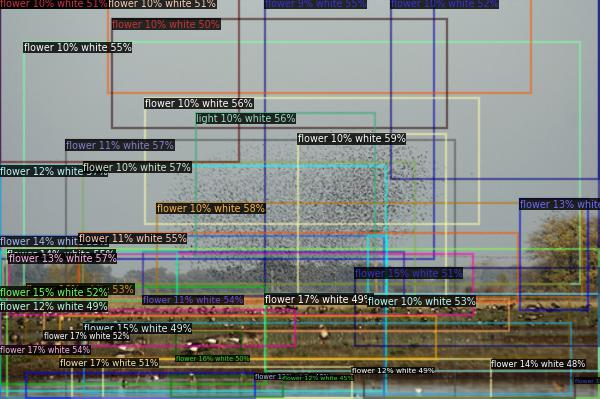

Feature Differences: -0.10296515
Object Ids Differences: 36
Attribute Ids Differences: 25
proposal_boxes:  [Boxes(tensor([[ 791.7982,  122.0252, 1161.6367,  513.6021],
        [ 223.2127,  200.1041,  792.9252,  496.3607],
        [ 259.0244,  268.4420,  532.6392,  459.3353],
        [   0.0000,  150.8840,  212.7484,  528.4835],
        [  56.0079,  564.1841,  173.0314,  736.6457],
        [ 265.2262,  187.0179,  514.7004,  512.7736],
        [  22.4315,  235.4355, 1041.0043,  798.6666],
        [ 734.6238,  141.7816, 1194.4053,  798.6666],
        [   0.0000,  136.9829,  742.0344,  769.9916],
        [ 492.9441,  356.9713,  567.7189,  443.0841],
        [ 500.5127,  361.1112,  568.3729,  427.7826],
        [ 138.1944,  403.1944,  876.1583,  798.6666],
        [ 873.3673,  216.1254, 1128.9773,  758.0874],
        [  16.6194,   16.3230, 1174.8329,  120.9671],
        [ 217.5906,    0.0000, 1194.4053,  510.7843],
        [ 466.8094,    0.0000, 1004.8475,  798.6666],
        [   0.0000,   

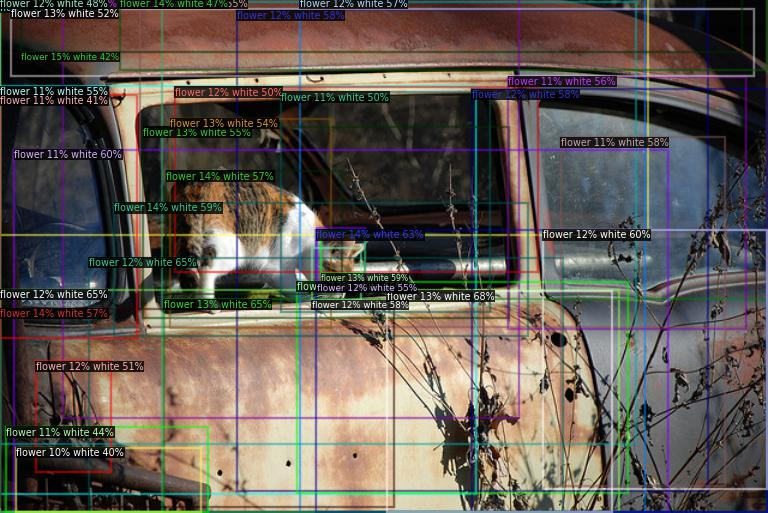

Feature Differences: -0.36913273
Object Ids Differences: 36
Attribute Ids Differences: 35
proposal_boxes:  [Boxes(tensor([[  72.8540,  717.1364,  844.9689,  798.6666],
        [   0.0000,    0.0000,  174.6874,  350.0365],
        [ 485.2982,  747.7185,  887.7050,  798.6666],
        [ 320.3340,   39.5477,  922.0143,  351.2712],
        [ 315.5341,  443.7890,  515.4547,  478.2754],
        [1044.3395,  328.3784, 1126.1874,  458.3377],
        [ 893.2054,  525.1761, 1264.0249,  602.1797],
        [ 783.3822,   51.3434, 1143.6724,  474.2133],
        [ 364.4038,  262.1493,  522.5369,  341.9503],
        [   0.0000,  384.9760,  280.2695,  737.2153],
        [ 785.2401,  543.1844,  907.8246,  589.1763],
        [ 230.6817,  179.7727, 1264.2006,  767.5552],
        [ 986.0805,  383.1505, 1298.1746,  514.0496],
        [1188.0952,  605.7639, 1295.4934,  649.0603],
        [  32.7462,  262.4216,  157.9874,  328.0007],
        [ 135.5951,  140.0694,  225.4444,  185.8424],
        [ 555.5278,  4

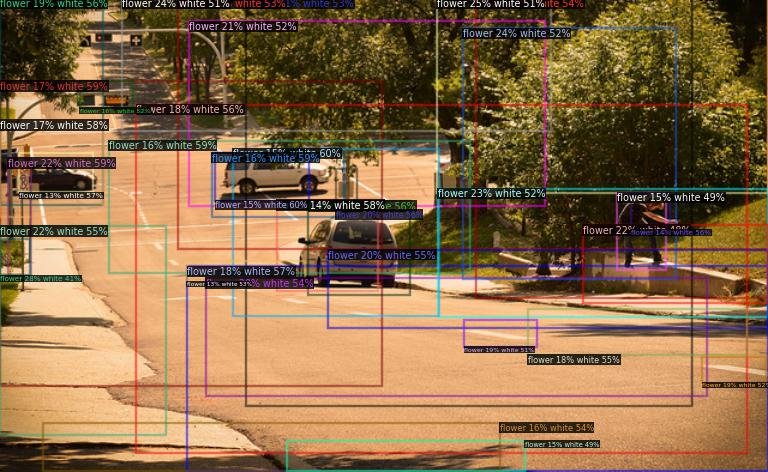

Feature Differences: -0.030880205
Object Ids Differences: 36
Attribute Ids Differences: 29
proposal_boxes:  [Boxes(tensor([[180.1401, 296.8806, 997.2828, 798.6667],
        [379.6896,  24.4823, 997.2828, 788.4473],
        [  0.0000, 446.5162, 692.1897, 798.6667],
        [ 67.8518, 651.4545, 934.9778, 798.6667],
        [549.4429, 503.8739, 778.0678, 606.3350],
        [145.0853, 682.1091, 878.4252, 798.6667],
        [320.4462, 106.8754, 926.3168, 404.0353],
        [ 39.6344, 390.9196, 783.0897, 558.1589],
        [  0.0000,   0.0000, 997.2828, 160.5670],
        [589.3270, 516.7413, 708.9047, 600.5502],
        [256.8092, 519.7137, 967.8074, 731.3542],
        [299.6227, 347.9344, 997.2828, 520.3380],
        [ 16.3600, 230.0228, 332.0945, 360.7314],
        [122.8706, 423.1283, 491.1152, 746.0029],
        [650.3357, 504.1028, 741.6978, 594.5021],
        [588.8535, 495.1031, 704.4660, 568.1041],
        [135.7645, 680.6558, 449.3004, 771.0128],
        [700.1860, 544.3605, 761.91

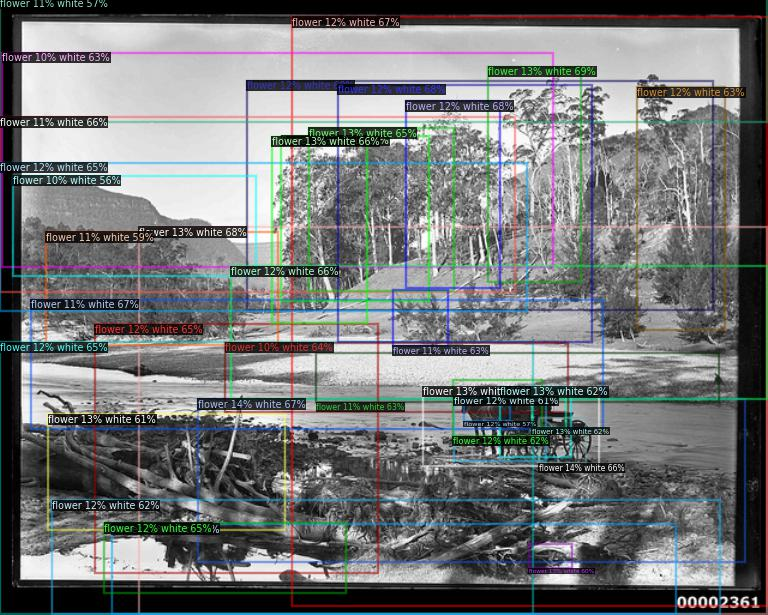

Feature Differences: -0.0958575
Object Ids Differences: 36
Attribute Ids Differences: 28
proposal_boxes:  [Boxes(tensor([[307.4961, 275.3481, 671.7081, 628.7130],
        [327.6330, 691.7062, 593.0967, 732.8333],
        [276.0396,  70.1783, 407.2051, 152.3230],
        [  0.0000, 494.5043, 833.5504, 798.6666],
        [181.7172,   0.0000, 231.8436, 676.4601],
        [  0.0000,   0.0000, 833.5504, 600.1594],
        [263.5825, 170.6001, 402.3745, 385.7672],
        [ 42.7195, 651.7440, 833.5504, 797.8118],
        [264.3318, 629.7342, 321.9358, 700.9673],
        [324.8071, 316.6974, 457.5884, 599.6165],
        [418.6033, 315.0376, 507.5067, 630.8801],
        [273.5876,  49.4959, 386.9810, 205.7013],
        [452.5854, 387.9879, 484.9893, 712.2736],
        [387.1454, 203.2513, 496.7058, 255.2379],
        [123.9462,   0.0000, 694.7628, 597.1526],
        [549.7039,  59.3156, 768.5127, 529.9725],
        [623.2622, 559.8564, 678.0948, 641.1508],
        [216.8572, 187.9776, 269.4124

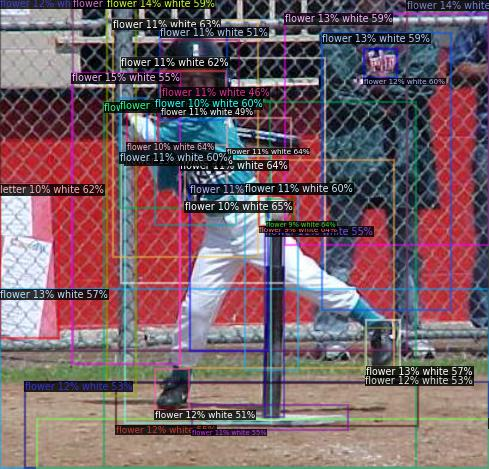

Feature Differences: -0.09001727
Object Ids Differences: 36
Attribute Ids Differences: 25
proposal_boxes:  [Boxes(tensor([[ 310.2448,  111.4882,  847.8314,  798.6667],
        [ 305.2083,  156.3752,  787.6815,  384.3560],
        [ 393.8169,  229.9989,  716.0342,  346.3653],
        [ 764.5950,    0.0000, 1065.6663,  620.7984],
        [ 441.3228,    0.0000,  797.0629,  294.6760],
        [ 349.3387,    0.0000,  482.5368,  316.1070],
        [ 144.5225,    0.0000,  359.6719,  444.7700],
        [ 201.0587,   13.8816,  356.3119,  159.3825],
        [   0.0000,  536.9910,  954.6082,  798.6667],
        [   0.0000,   11.4761,  206.7674,  599.2020],
        [ 671.6238,  552.0323,  801.7772,  628.8468],
        [ 806.3785,  125.7338,  932.0463,  399.5561],
        [  62.4933,    0.0000, 1065.6663,  503.6254],
        [ 179.8887,  340.0902,  528.1440,  681.6739],
        [ 240.6444,  666.3340,  331.7165,  724.1064],
        [ 188.8715,  662.3609,  431.6024,  798.6667],
        [   0.0000,  5

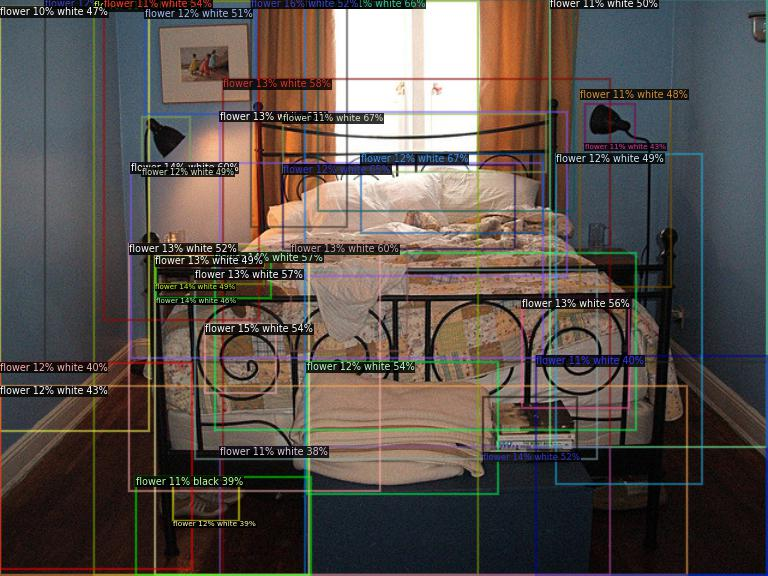

Feature Differences: -0.19054121
Object Ids Differences: 36
Attribute Ids Differences: 30
proposal_boxes:  [Boxes(tensor([[   0.0000,  532.3651,  459.2759,  780.8356],
        [   0.0000,    0.0000, 1167.0287,  379.7090],
        [ 822.1855,    5.3106, 1185.2916,  352.7220],
        [ 150.1785,  262.2345,  447.0952,  533.8656],
        [   1.7121,  510.5338,  178.9635,  685.6768],
        [ 370.5202,  205.4994,  695.5326,  582.3349],
        [ 222.9232,  204.8898, 1194.6705,  798.6667],
        [   0.0000,  156.0885,  688.7899,  798.6667],
        [ 503.2563,  202.8388,  657.2874,  374.7404],
        [1020.9314,    0.0000, 1188.4240,  138.0203],
        [1041.6536,  250.8642, 1083.6860,  301.4007],
        [ 327.0176,  751.1023,  369.8861,  797.5411],
        [ 571.4364,  403.9694, 1197.2701,  798.6667],
        [ 793.9670,   55.4489, 1041.9094,  453.7672],
        [ 437.0388,  318.5824,  647.8273,  542.7789],
        [  87.5394,  249.7836,  459.9861,  570.8122],
        [ 636.6902,   

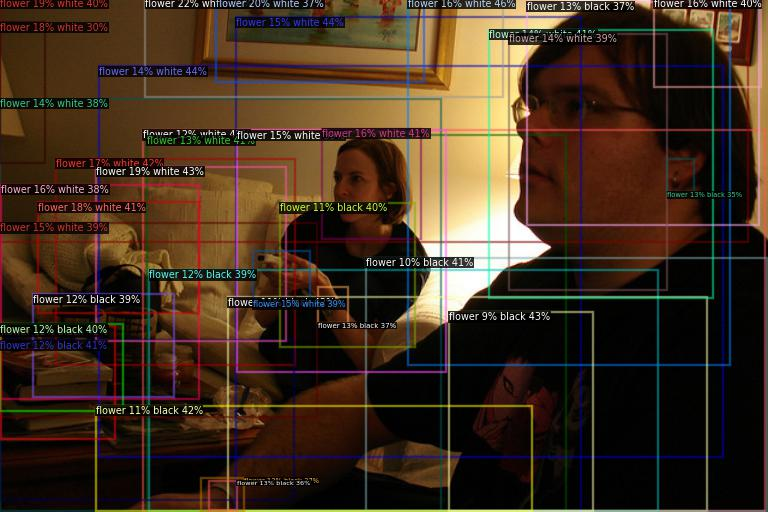

Feature Differences: -0.12931249
Object Ids Differences: 36
Attribute Ids Differences: 30
proposal_boxes:  [Boxes(tensor([[ 363.7998,  300.0501,  505.8147,  601.8058],
        [ 115.2484,    0.0000, 1308.3114,  120.2080],
        [ 257.1319,   27.9740, 1309.8643,  522.6255],
        [ 354.6927,  256.8819,  499.0748,  405.6270],
        [ 190.6787,  296.6436, 1254.1617,  748.0000],
        [ 140.4066,  261.1186,  303.3168,  395.2983],
        [   0.0000,    0.0000,  633.5206,  626.5874],
        [ 102.3146,  210.8572,  307.4101,  577.7925],
        [1268.3983,  215.7209, 1331.6670,  301.7863],
        [ 981.1096,  522.3990, 1231.2516,  674.4090],
        [  99.1346,   86.4456,  992.1807,  282.7244],
        [ 233.6648,  491.8495,  424.1393,  690.3759],
        [ 874.2092,  540.8619,  970.4398,  638.1951],
        [ 246.6962,  547.8579,  446.7530,  717.2039],
        [ 832.8905,  502.4862, 1001.2122,  674.2554],
        [ 677.9432,  340.4755,  817.9724,  490.9627],
        [1051.0123,  5

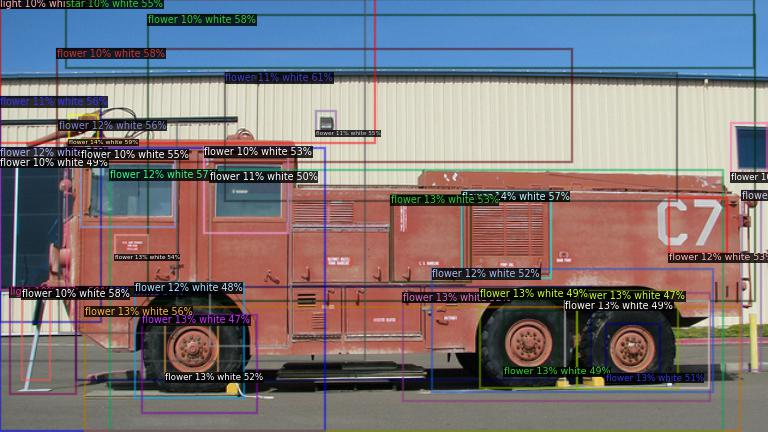

Feature Differences: -0.08925146
Object Ids Differences: 36
Attribute Ids Differences: 28
proposal_boxes:  [Boxes(tensor([[  25.9741,   25.5701,  798.6667,  222.9187],
        [ 337.1982,  233.5903,  442.6066,  304.4327],
        [ 271.1817,  639.7489,  328.7346,  709.3972],
        [ 293.4724,  635.0021,  456.3943,  861.4130],
        [ 380.7512,  834.8602,  770.7339, 1213.2645],
        [ 223.1648,  339.6502,  541.7186,  683.0519],
        [ 332.2222,  225.3569,  445.9588,  391.4459],
        [ 208.4305,  765.3354,  522.7884, 1063.0695],
        [   0.0000,  334.3490,  544.8431, 1127.3169],
        [ 174.8936,  161.4726,  566.3877, 1063.4087],
        [ 347.6827,  281.0417,  437.0928,  355.6917],
        [ 503.6510,  448.3453,  753.5502,  909.0115],
        [ 449.7686,  274.3220,  798.6667, 1220.5988],
        [ 274.7050,  228.9445,  484.2017,  354.6757],
        [ 249.2662,  325.9443,  510.5945,  873.7368],
        [   0.0000,  903.1917,  798.6667, 1256.0148],
        [ 212.4134,  6

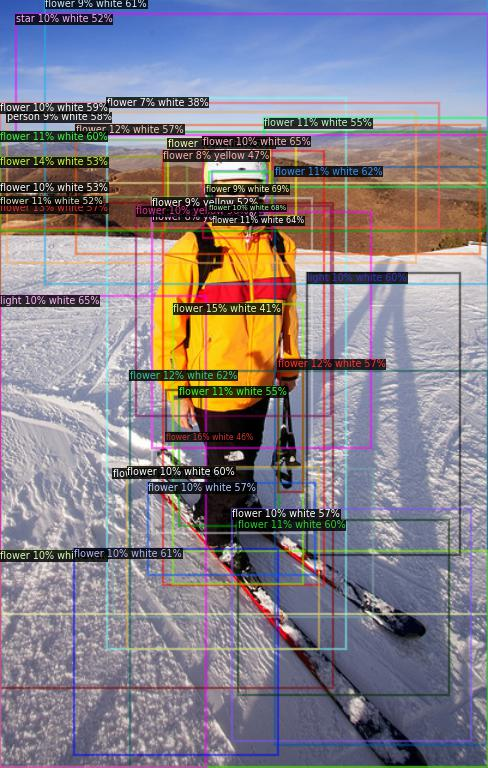

Feature Differences: -0.08649654
Object Ids Differences: 36
Attribute Ids Differences: 23
proposal_boxes:  [Boxes(tensor([[ 614.1261,  265.3050,  953.6884,  456.4687],
        [ 913.4258,  390.1993, 1121.6685,  675.6032],
        [ 282.9853,  420.1398,  499.9607,  798.6666],
        [ 674.5601,   10.7408, 1168.0502,  266.4745],
        [ 680.3322,   91.2440, 1168.0502,  798.6666],
        [   0.0000,    0.0000, 1078.5210,  391.3600],
        [ 230.9394,  397.8109, 1168.0502,  798.6666],
        [ 624.8627,    0.0000, 1168.0502,  461.0023],
        [ 412.9113,  394.6100,  780.9045,  765.4257],
        [ 637.2515,   75.7176,  739.1052,  375.2863],
        [ 149.0445,  190.0487,  527.5000,  543.1750],
        [   0.0000,    0.0000,  550.7639,  490.0551],
        [ 151.2771,  106.2297,  905.2830,  798.6666],
        [   0.0000,   50.6306,  534.2383,  266.2374],
        [ 136.3269,  179.0262,  611.8997,  798.6666],
        [   0.0000,  200.4621,  497.3454,  569.9204],
        [   0.0000,   

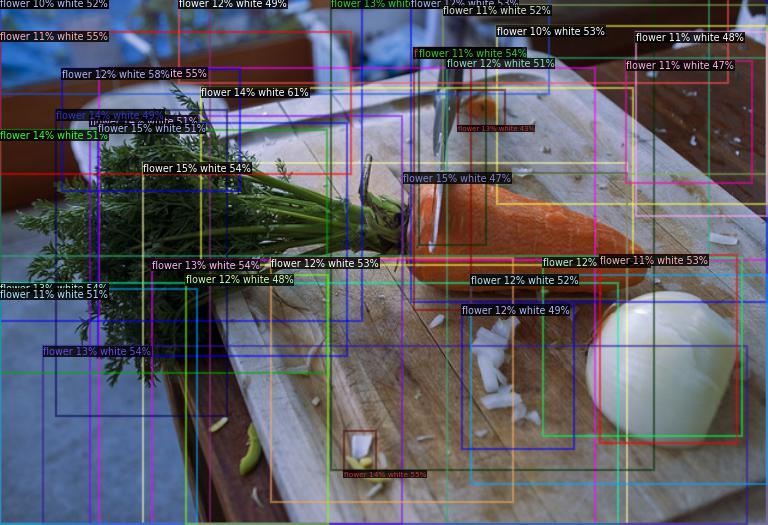

Feature Differences: -0.34207222
Object Ids Differences: 36
Attribute Ids Differences: 30


In [12]:
# Show the boxes, labels, and features
#FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              #"attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]
for datum in data:
    im = cv2.imread('data/images/' + datum['img_id'] + '.jpg')
    given_boxes = datum['boxes']
    instances, features = doit(im, given_boxes)
    pred = instances.to('cpu')
    v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=1.2)
    v = v.draw_instance_predictions(pred)
    showarray(v.get_image()[:, :, ::-1])
    print("Feature Differences:", (features.cpu().numpy() - datum['features']).mean())
    print("Object Ids Differences:", (instances.pred_classes.cpu().numpy() != datum['objects_id']).sum())
    print("Attribute Ids Differences:", (instances.attr_classes.cpu().numpy() != datum['attrs_id']).sum())
    
